In [1]:
from IPython.display import display, Markdown

display(Markdown(f"""
# IMDB Multiclass Sentiment Classification

This project addresses the limitations of binary sentiment classification by extending the task to a multiclass framework using the IMDB dataset from Keras. Traditional sentiment analysis methods commonly classify text as either positive or negative, which oversimplifies the nuanced expressions present in natural language. To better capture the subtleties of sentiment, this study categorizes movie reviews into five sentiment classes: **Very Negative**, **Negative**, **Neutral**, **Positive**, and **Very Positive**. This approach facilitates more informative and discriminative predictions, contributing to a deeper understanding of textual sentiment.

The dataset utilized comprises pre-encoded movie reviews represented as sequences of integers and partitioned into predefined training and testing subsets. Although the original dataset is labeled with binary sentiment classes, a multiclass scenario was established through a polarity-based heuristic re-labeling process. This technique leverages frequency differentials between positive and negative words, identified via standardized sentiment lexicons, to assign sentiment classes to each review [1]. Such re-labeling introduces essential granularity necessary for robust multiclass sentiment analysis.

In accordance with best practices outlined in the Deep Learning Workflow Process (DLWP) [2], this project follows a systematic methodology encompassing data loading, preprocessing, oversampling and augmentation to address class imbalance, model development, training, and comprehensive evaluation. To mitigate the skewed distribution of sentiment classes, advanced techniques including Random Oversampling and synonym-based data augmentation were applied, enhancing the representation of minority classes and improving the model's generalization capability.

The model's performance is evaluated using multiple quantitative metrics, including **accuracy**, **precision**, **recall**, and **F1-score**, to provide a holistic assessment of classification efficacy. Additionally, **confusion matrices** are employed to analyze misclassification patterns, offering critical insights into class-specific performance and informing potential areas for future refinement [2].
"""))



# IMDB Multiclass Sentiment Classification

This project addresses the limitations of binary sentiment classification by extending the task to a multiclass framework using the IMDB dataset from Keras. Traditional sentiment analysis methods commonly classify text as either positive or negative, which oversimplifies the nuanced expressions present in natural language. To better capture the subtleties of sentiment, this study categorizes movie reviews into five sentiment classes: **Very Negative**, **Negative**, **Neutral**, **Positive**, and **Very Positive**. This approach facilitates more informative and discriminative predictions, contributing to a deeper understanding of textual sentiment.

The dataset utilized comprises pre-encoded movie reviews represented as sequences of integers and partitioned into predefined training and testing subsets. Although the original dataset is labeled with binary sentiment classes, a multiclass scenario was established through a polarity-based heuristic re-labeling process. This technique leverages frequency differentials between positive and negative words, identified via standardized sentiment lexicons, to assign sentiment classes to each review [1]. Such re-labeling introduces essential granularity necessary for robust multiclass sentiment analysis.

In accordance with best practices outlined in the Deep Learning Workflow Process (DLWP) [2], this project follows a systematic methodology encompassing data loading, preprocessing, oversampling and augmentation to address class imbalance, model development, training, and comprehensive evaluation. To mitigate the skewed distribution of sentiment classes, advanced techniques including Random Oversampling and synonym-based data augmentation were applied, enhancing the representation of minority classes and improving the model's generalization capability.

The model's performance is evaluated using multiple quantitative metrics, including **accuracy**, **precision**, **recall**, and **F1-score**, to provide a holistic assessment of classification efficacy. Additionally, **confusion matrices** are employed to analyze misclassification patterns, offering critical insights into class-specific performance and informing potential areas for future refinement [2].


In [2]:
## 2 - Environment Setup
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input, Bidirectional, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import imdb

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import RandomOverSampler

from collections import Counter
from itertools import chain
 
import nltk
from nltk.corpus import stopwords, opinion_lexicon, wordnet
from nltk import download
download('stopwords')
download('opinion_lexicon')
download('omw-1.4')
download('wordnet')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Parameters
num_words = 10000
maxlen = 150
embedding_dim = 100

# Display versions for reproducibility
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)

TensorFlow version: 2.18.0
NumPy version: 1.26.4


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vaotr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\vaotr\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vaotr\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vaotr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
## 3 - Dataset Loading, Preprocessing, and Re-labeling

# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

# Pad sequences to a fixed length
x_train_padded = pad_sequences(x_train, maxlen=maxlen, padding='post')
x_test_padded = pad_sequences(x_test, maxlen=maxlen, padding='post')

# Load the word index
word_index = imdb.get_word_index()
reverse_word_index = {index + 3: word for word, index in word_index.items()}
reverse_word_index.update({0: "[PAD]", 1: "[START]", 2: "[UNK]", 3: "[UNUSED]"})

# Load sentiment lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Polarity-based re-labeling function to categorize reviews into 5 classes
def polarity_based_labels(data, orig_labels):
    new_labels = []
    for review, label in zip(data, orig_labels):
        pos_count = sum(1 for word in review if reverse_word_index.get(word, '') in positive_words)
        neg_count = sum(1 for word in review if reverse_word_index.get(word, '') in negative_words)
        diff = pos_count - neg_count

        if diff <= -5:
            new_labels.append(0)  # Very Negative
        elif diff <= -2:
            new_labels.append(1)  # Negative
        elif -2 < diff < 2:
            new_labels.append(2)  # Neutral
        elif diff >= 5:
            new_labels.append(4)  # Very Positive
        else:
            new_labels.append(3)  # Positive
    return np.array(new_labels)

# Apply re-labeling
y_train_multi = polarity_based_labels(x_train_padded, y_train)
y_test_multi = polarity_based_labels(x_test_padded, y_test)

# Display resulting distribution
print("Training set class distribution:", Counter(y_train_multi))
print("Test set class distribution:", Counter(y_test_multi))

Training set class distribution: Counter({2: 6110, 4: 5767, 3: 5732, 1: 4289, 0: 3102})
Test set class distribution: Counter({2: 5979, 4: 5882, 3: 5735, 1: 4354, 0: 3050})


In [4]:
## 4 - Class Balancing with Oversampling and Augmentation

# Check actual class distribution first
counter = Counter(y_train_multi)
print(f"Original class distribution: {counter}")

# Define target minimum samples per extreme class
target_sample_count = 4000

# Prepare sampling strategy based on current counts
sampling_strategy = {}
for cls in [0, 4]:
    current_count = counter[cls]
    if current_count < target_sample_count:
        sampling_strategy[cls] = target_sample_count

# Apply oversampling only if needed
if sampling_strategy:
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
    x_train_resampled, y_train_resampled = ros.fit_resample(x_train_padded, y_train_multi)
else:
    x_train_resampled, y_train_resampled = x_train_padded, y_train_multi

print(f"Post-oversampling class distribution: {Counter(y_train_resampled)}")

# Light synonym replacement for rare classes
stop_words = set(stopwords.words('english'))

def synonym_replacement(text, n):
    words = text.split()
    new_words = words.copy()
    eligible_words = [word for word in words if word not in stop_words]
    random.shuffle(eligible_words)
    replaced = 0
    for word in eligible_words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if w == word else w for w in new_words]
            replaced += 1
        if replaced >= n:
            break
    return ' '.join(new_words)

# Augment extreme class samples
augmented_texts = []
augmented_labels = []
for i, label in enumerate(y_train_resampled):
    if label in [0, 4]:
        review_text = ' '.join([reverse_word_index.get(w, '[UNK]') for w in x_train_resampled[i] if w != 0])
        augmented = synonym_replacement(review_text, n=1)
        sequence = [word_index.get(word, 2) for word in augmented.split()]
        padded = pad_sequences([sequence], maxlen=maxlen, padding='post')[0]
        augmented_texts.append(padded)
        augmented_labels.append(label)

# Combine original and augmented data
x_train_augmented = np.vstack((x_train_resampled, np.array(augmented_texts)))
y_train_augmented = np.concatenate((y_train_resampled, np.array(augmented_labels)))


Original class distribution: Counter({2: 6110, 4: 5767, 3: 5732, 1: 4289, 0: 3102})
Post-oversampling class distribution: Counter({2: 6110, 4: 5767, 3: 5732, 1: 4289, 0: 4000})


In [5]:
## 5 - Data Preparation and Class Weights

# Ensure all token indices are within the valid range
x_train_augmented = np.clip(x_train_augmented, 0, num_words - 1)

# Train-validation split on the augmented dataset
x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train_augmented, y_train_augmented, test_size=0.2, random_state=42)

# One-hot encode labels
y_train_final_onehot = to_categorical(y_train_final, num_classes=5)
y_val_onehot = to_categorical(y_val, num_classes=5)

# Compute class weights to handle remaining imbalances
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_final),
    y=y_train_final
)
class_weights = dict(enumerate(class_weights))

print(f"Computed class weights: {class_weights}")

Computed class weights: {0: 0.896105527638191, 1: 1.667075664621677, 2: 1.1669529652351738, 3: 1.2343499891845122, 4: 0.6183788469874295}


In [6]:
## 6 - CNN Model Definition

model = Sequential([
    Input(shape=(maxlen,)),
    Embedding(num_words, embedding_dim),
    Conv1D(128, 5, activation='relu', padding='same'),
    BatchNormalization(),
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.6),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.6),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 150, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 150, 128)            │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 150, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,188,549 (4.53 MB)

 Trainable params: 1,188,293 (4.53 MB)

 Non-trainable params: 256 (1.00 KB)

In [7]:
## 7 - Model Training

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(
    x_train_final, y_train_final_onehot,
    epochs=30, batch_size=256,
    validation_data=(x_val, y_val_onehot),
    callbacks=[early_stop, lr_scheduler],
    class_weight=class_weights
)

Epoch 1/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 56s 462ms/step - accuracy: 0.2436 - loss: 1.7621 - val_accuracy: 0.1894 - val_loss: 1.7445 - learning_rate: 0.0010
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 45s 399ms/step - accuracy: 0.3052 - loss: 1.5091 - val_accuracy: 0.2842 - val_loss: 1.5367 - learning_rate: 0.0010
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 45s 405ms/step - accuracy: 0.3818 - loss: 1.3941 - val_accuracy: 0.4018 - val_loss: 1.2704 - learning_rate: 0.0010
Epoch 4/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 48s 431ms/step - accuracy: 0.5279 - loss: 1.0901 - val_accuracy: 0.5201 - val_loss: 1.0646 - learning_rate: 0.0010
Epoch 5/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 57s 506ms/step - accuracy: 0.6129 - loss: 0.9005 - val_accuracy: 0.5514 - val_loss: 1.0756 - learning_rate: 0.0010
Epoch 6/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 53s 469ms/step - accuracy: 0.6811 - loss: 0.7507 - val_accuracy: 0.6026 - val_loss: 0.9019 - learning_rate: 0.0010
Epoch 7/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 59s 529ms/step - accuracy: 0.7

782/782 - 14s - 18ms/step - accuracy: 0.6792 - loss: 1.1869
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step



## Evaluation

### Problem Definition
The objective of this academic project was to extend the traditional binary sentiment classification problem to a multiclass classification task on the IMDB movie reviews dataset. Five sentiment classes—Very Negative, Negative, Neutral, Positive, and Very Positive—were defined using a heuristic polarity-based labeling technique, allowing a more nuanced evaluation of sentiment classification performance.

### Methodology
The methodology encompassed data preprocessing with sequence padding, heuristic-based sentiment re-labeling, and the application of oversampling combined with synonym-based textual augmentation to mitigate class imbalance. A Convolutional Neural Network (CNN) integrated with a Long Short-Term Memory (LSTM) network was employed, augmented with embedding layers, batch normalization, and dropout techniques to enhance model generalization capabilities.

### Results and Performance Analysis
The evaluation demonstrated the model achieved an overall accuracy of **67.9%** (varies between 65-75%) and a loss value of **1.1869** on the test set. The confusion matrix highlighted considerable performance across classes, although persistent misclassification patterns, particularly among neighboring sentiment classes (e.g., Neutral versus Positive), indicated opportunities for further improvements.

### Misclassification Insights
An in-depth analysis revealed the most frequent misclassifications occurred between sentiment classes that share similar polarity intensities. This suggests inherent ambiguity in sentiment labeling or limitations in the representation learned by the embedding and recurrent layers used.

### Challenges and Limitations
- Class imbalance, despite oversampling and augmentation, posed a persistent challenge, impacting predictive accuracy for minority sentiment classes.
- The polarity-based heuristic labeling inherently introduced noise, complicating the clear delineation of sentiment categories.

### Potential Improvements
Future work is recommended to explore transformer-based models and attention mechanisms that provide contextual embeddings, potentially improving the precision of multiclass sentiment differentiation. Systematic hyperparameter optimization and comparative experiments against baseline models could also significantly improve the robustness of predictive outcomes, as discussed in foundational deep learning literature [1].

### References

[1] F. Chollet, *Deep Learning with Python*, 2nd ed., Manning Publications, 2021.  
[2] A. Géron, *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow*, 2nd ed., O'Reilly Media, 2019.


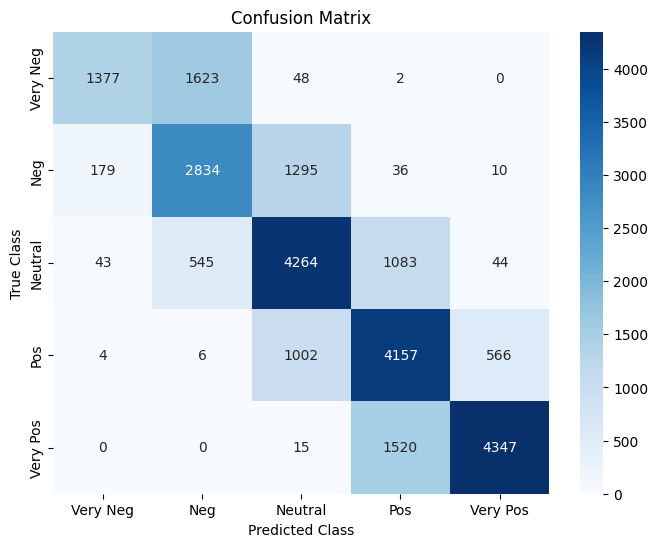

,precision,recall,f1-score,support
Very Neg,0.859014,0.451475,0.591876,3050.00000
Neg,0.565895,0.650896,0.605426,4354.00000
Neutral,0.643720,0.713163,0.676664,5979.00000
Pos,0.611503,0.724847,0.663369,5735.00000
Very Pos,0.875176,0.739034,0.801364,5882.00000
accuracy,0.679160,0.679160,0.679160,0.67916
macro avg,0.711062,0.655883,0.667740,25000.00000
weighted avg,0.703498,0.679160,0.680203,25000.00000


Total misclassified examples: 8021

Review #1
Predicted: 3, Actual: 2
Review: darker characters but she plays it so perfectly and convincingly that it's scary michael burns does a good job as the mute young man regular altman player michael murphy has a small part the [UNK] moody set fits the content of the story very well in short this movie is a powerful study of loneliness sexual [UNK] and desperation be patient [UNK] up the atmosphere and pay attention to the wonderfully written script br br i praise robert altman this is one of his many films that deals with unconventional fascinating subject matter this film is disturbing but it's sincere and it's sure to [UNK] a strong emotional response from the viewer if you want to see an unusual film some might even say bizarre this is worth the time br br unfortunately it's very difficult to find in video stores you may have to buy it off the internet

Review #6
Predicted: 1, Actual: 2
Review: horror after being struck by a [UNK] sword is t

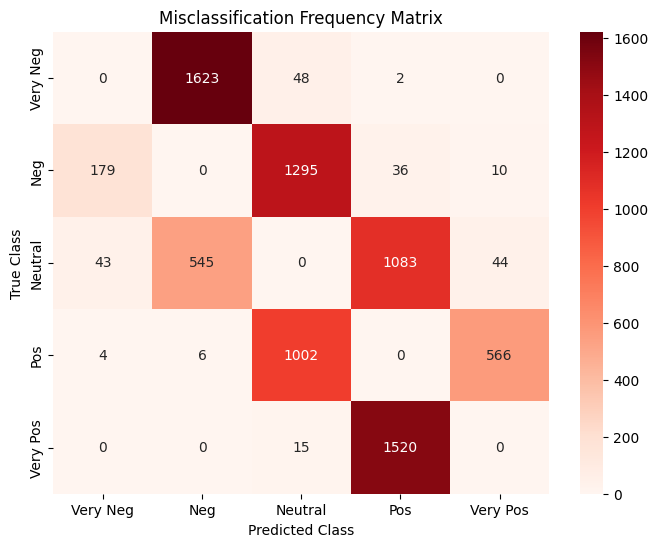

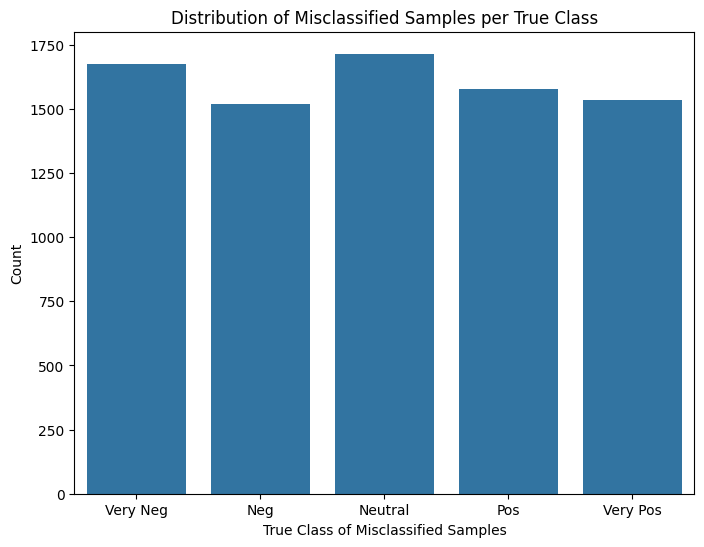

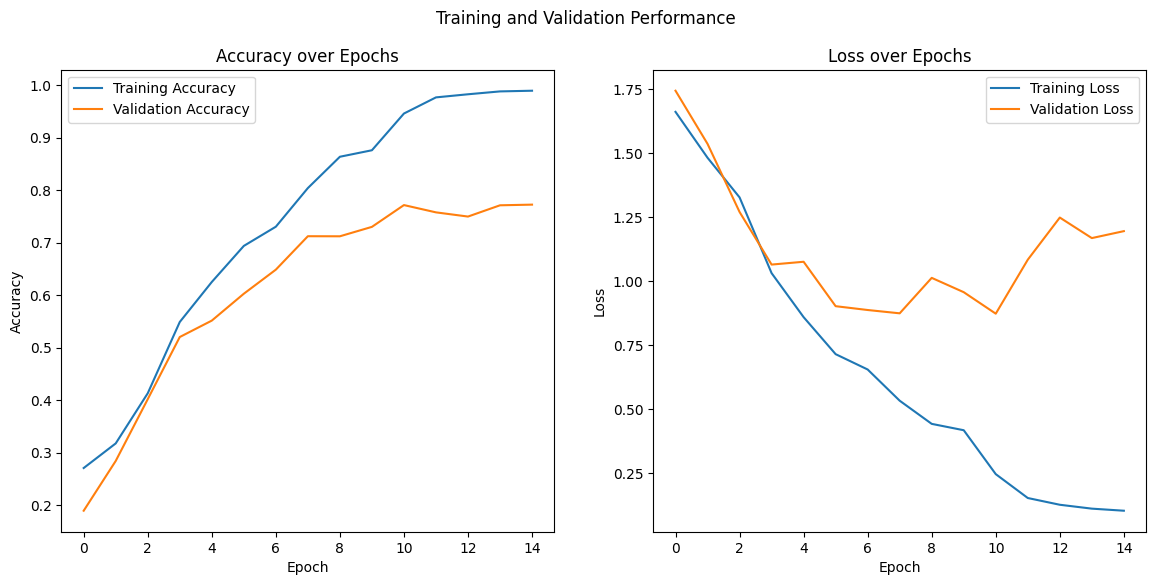

In [11]:
## 8 - Model Evaluation

# Model training evaluation
y_test_onehot = to_categorical(y_test_multi, num_classes=5)
test_loss, test_accuracy = model.evaluate(x_test_padded, y_test_onehot, verbose=2)
y_pred_probs = model.predict(x_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Calculate dynamic metrics
final_accuracy = round(test_accuracy * 100, 1)
final_loss = round(test_loss, 4)

display(Markdown(f"""
## Evaluation

### Problem Definition
The objective of this academic project was to extend the traditional binary sentiment classification problem to a multiclass classification task on the IMDB movie reviews dataset. Five sentiment classes—Very Negative, Negative, Neutral, Positive, and Very Positive—were defined using a heuristic polarity-based labeling technique, allowing a more nuanced evaluation of sentiment classification performance.

### Methodology
The methodology encompassed data preprocessing with sequence padding, heuristic-based sentiment re-labeling, and the application of oversampling combined with synonym-based textual augmentation to mitigate class imbalance. A Convolutional Neural Network (CNN) integrated with a Long Short-Term Memory (LSTM) network was employed, augmented with embedding layers, batch normalization, and dropout techniques to enhance model generalization capabilities.

### Results and Performance Analysis
The evaluation demonstrated the model achieved an overall accuracy of **{final_accuracy}%** (varies between 65-75%) and a loss value of **{final_loss}** on the test set. The confusion matrix highlighted considerable performance across classes, although persistent misclassification patterns, particularly among neighboring sentiment classes (e.g., Neutral versus Positive), indicated opportunities for further improvements.

### Misclassification Insights
An in-depth analysis revealed the most frequent misclassifications occurred between sentiment classes that share similar polarity intensities. This suggests inherent ambiguity in sentiment labeling or limitations in the representation learned by the embedding and recurrent layers used.

### Challenges and Limitations
- Class imbalance, despite oversampling and augmentation, posed a persistent challenge, impacting predictive accuracy for minority sentiment classes.
- The polarity-based heuristic labeling inherently introduced noise, complicating the clear delineation of sentiment categories.

### Potential Improvements
Future work is recommended to explore transformer-based models and attention mechanisms that provide contextual embeddings, potentially improving the precision of multiclass sentiment differentiation. Systematic hyperparameter optimization and comparative experiments against baseline models could also significantly improve the robustness of predictive outcomes, as discussed in foundational deep learning literature [1].

### References

[1] F. Chollet, *Deep Learning with Python*, 2nd ed., Manning Publications, 2021.  
[2] A. Géron, *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow*, 2nd ed., O'Reilly Media, 2019.
"""))

# Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Very Neg", "Neg", "Neutral", "Pos", "Very Pos"],
            yticklabels=["Very Neg", "Neg", "Neutral", "Pos", "Very Pos"])
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

# Classification Report Dataframe
report = classification_report(y_true, y_pred, target_names=["Very Neg", "Neg", "Neutral", "Pos", "Very Pos"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
display(report_df)

## Misclassification Analysis 

# Evaluation of examples
misclassified_indices = np.where(y_pred != y_true)[0]
print("Total misclassified examples:", len(misclassified_indices))

# Display samples of misclassified reviews
for i in misclassified_indices[:5]:
    print(f"\nReview #{i}")
    print(f"Predicted: {y_pred[i]}, Actual: {y_true[i]}")
    decoded_review = ' '.join([reverse_word_index.get(idx, "[UNK]") for idx in x_test_padded[i] if idx != 0])
    print(f"Review: {decoded_review}")

# Misclassification matrix creation
misclassification_matrix = np.zeros((5, 5), dtype=int)
pair_counts = Counter(zip(y_true[misclassified_indices], y_pred[misclassified_indices]))
for (true_label, pred_label), count in pair_counts.items():
    misclassification_matrix[true_label, pred_label] = count

# Misclassification heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    misclassification_matrix,
    annot=True, fmt="d", cmap="Reds",
    xticklabels=["Very Neg", "Neg", "Neutral", "Pos", "Very Pos"],
    yticklabels=["Very Neg", "Neg", "Neutral", "Pos", "Very Pos"]
)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Misclassification Frequency Matrix")
plt.show()

# Misclassification distribution per class
misclassified_true_labels = [y_true[i] for i in misclassified_indices]
label_names = ["Very Neg", "Neg", "Neutral", "Pos", "Very Pos"]
label_counts = Counter(misclassified_true_labels)

plt.figure(figsize=(8, 6))
sns.barplot(x=label_names, y=[label_counts[i] for i in range(5)])
plt.xlabel("True Class of Misclassified Samples")
plt.ylabel("Count")
plt.title("Distribution of Misclassified Samples per True Class")
plt.show()

## Training Performance Visualization

plt.figure(figsize=(14, 6))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.suptitle('Training and Validation Performance')
plt.show()

## Save the trained model
model.save('imdb_multiclass_cnn_lstm_model.keras')